# Decision Tree Classification for Molecular Solubility Prediction

## Workshop: ML4Science 2025 - Classification without Fingerprints

---

### Notebook Overview

This notebook demonstrates the application of **Decision Tree Classification** for predicting the solubility of organic compounds using the **ESOL (Estimated SOLubility) dataset**. Unlike traditional cheminformatics approaches that rely on molecular fingerprints, we use basic molecular descriptors calculated directly from SMILES strings.

**Learning Objectives:**
- Load and preprocess molecular datasets
- Calculate molecular descriptors using RDKit
- Build and evaluate Decision Tree classifiers  
- Compare Decision Trees with Random Forest ensembles
- Understand hyperparameter tuning and overfitting

**Dataset:** ESOL - A curated dataset of 1,128 organic compounds with measured aqueous solubility values

**Task:** Binary classification (soluble vs. insoluble) based on a threshold of 0.05 g/L

---

## 1. Import Libraries

We begin by importing all necessary libraries for data manipulation, machine learning, and chemical informatics.

In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import requests
from io import StringIO
import seaborn as sns

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

!pip install rdkit

# Chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors

---

## 2. Load and Explore the ESOL Dataset

The ESOL (Estimated SOLubility) dataset contains:
- **1,128 organic compounds**
- SMILES representations
- Measured log solubility values (LogS)
- Predicted values from the original ESOL model

We'll load this dataset and examine its structure.

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']
Dataset shape: (1128, 3)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS  \
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77   
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30   
2                               CC(C)=CCCC(C)=CC(=O) -2.06   
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87   
4                                            c1ccsc1 -1.33   

   ESol_Predicted_LogS  
0               -0.974  
1               -2.885  
2               -2.579  
3               -6.618  
4               -2.232  


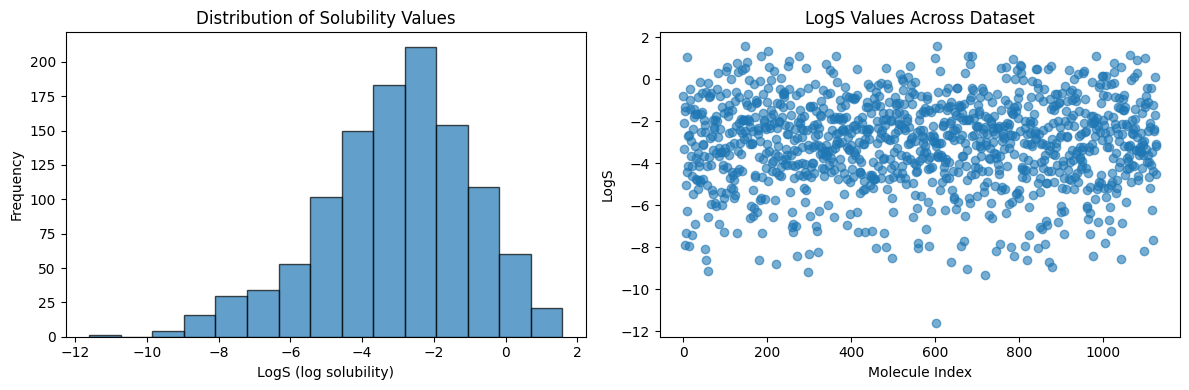

In [30]:

def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS','ESol_Predicted_LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()
print(f"Dataset shape: {df.shape}")
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")
print("\nSample data:")
print(df.head())

# Visualize distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

---

## 3. Calculate Molecular Descriptors

Instead of using molecular fingerprints, we calculate basic molecular descriptors using RDKit:
- **MolWt**: Molecular weight
- **MolLogP**: Partition coefficient (lipophilicity)
- **NumHDonors**: Number of hydrogen bond donors
- **NumHAcceptors**: Number of hydrogen bond acceptors
- **NumRotatableBonds**: Number of rotatable bonds
- **TPSA**: Topological polar surface area
- **Aromatic Proportion** : fraction of heavy atoms that are aromatic
- **Non Carbon Proportion** : fraction of heavy atoms that are not carbon

These descriptors capture important physicochemical properties that influence solubility.

In [31]:
# Basic descriptors available in all RDKit versions
descriptor_functions = [
    ('MolWt', Descriptors.MolWt),
    ('LogP', Descriptors.MolLogP),
    ('NumHDonors', Descriptors.NumHDonors),
    ('NumHAcceptors', Descriptors.NumHAcceptors),
    ('TPSA', Descriptors.TPSA),
    ('NumRotatableBonds', Descriptors.NumRotatableBonds),
]
def calculate_molecular_descriptors(smiles_list,descriptor_functions=None):
    """Calculate traditional molecular descriptors
    returns a DataFrame with descriptors for each SMILES string"""
    descriptors = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            descriptors.append([0] * len(descriptor_functions))
            continue

        mol_descriptors = []
        for name, func in descriptor_functions:
            try:
                value = func(mol)
                mol_descriptors.append(value if value is not None else 0)
            except:
                mol_descriptors.append(0)
        # Now we calculate some additional descriptors, like aromatic proportion(fraction of heavy atoms that are aromatic)
        # and non-carbon proportion(fraction of heavy atoms that are not carbon)
        aromatic_atoms_count = 0
        for atom in mol.GetAtoms():
            if atom.GetIsAromatic():
                aromatic_atoms_count += 1
        heavy_atoms_count = mol.GetNumHeavyAtoms()
        aromatic_proportion = aromatic_atoms_count / heavy_atoms_count if heavy_atoms_count > 0 else 0
        mol_descriptors.append(aromatic_proportion)
        carbon_count = 0
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 6:
                carbon_count += 1
        non_carbon_proportion = (heavy_atoms_count - carbon_count) / heavy_atoms_count if heavy_atoms_count > 0 else 0
        mol_descriptors.append(non_carbon_proportion)

        descriptors.append(mol_descriptors)
    return pd.DataFrame(descriptors,columns=[name for name, _ in descriptor_functions] + ['AromaticProportion', 'NonCarbonProportion'])

---

## 4. Prepare Data for Classification

### 4.1 Define Solubility Threshold

For classification, we need to convert continuous solubility values into binary labels (soluble/insoluble). We'll analyze the distribution of solubility values to choose an appropriate threshold.

(2 possible candidate values are 10 uG/mL or 50 uG/mL. (Sun H, Shah P, Nguyen K, Yu KR, Kerns E, Kabir M, Wang Y, Xu X. Predictive models of aqueous solubility of organic compounds built on A large dataset of high integrity.))

First, convert LogS to actual solubility in mol/L and g/L:

In [32]:
df['S(in mol/L)'] = np.power(10,df['LogS']) #log in base 10 in chemistry
weights = []
for smile in df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    mol_wt = Descriptors.MolWt(mol)
    weights.append(mol_wt)
df['mol_wt']=weights
df['S(in g/L)']=df['S(in mol/L)']*df['mol_wt']

### 4.2 Analyze Solubility Distribution

Let's examine the statistical distribution of solubility values to inform our threshold selection.

In [33]:
print(f"mean S : {np.mean(df['S(in g/L)'])}")
print(f"std_dev S : {np.std(df['S(in g/L)'])}")
print(f"median S : {np.median(df['S(in g/L)'])}")
print(f"Fraction of moleculess with S less than 0.01 :  {np.mean(df['S(in g/L)'] < 0.01)}")
print(f"Fraction of moleculess with S less than 0.05 :  {np.mean(df['S(in g/L)'] < 0.05)}")



mean S : 39.4439457174898
std_dev S : 210.11273599723103
median S : 0.23663219919698467
Fraction of moleculess with S less than 0.01 :  0.24113475177304963
Fraction of moleculess with S less than 0.05 :  0.35815602836879434


**Observation:** The molecules are more evenly distributed around a threshold of **0.05 g/L**. This makes it a good choice for balanced binary classification.

### 4.3 Create Binary Labels

Create the target variable `is_soluble` where:
- **1 (soluble)**: S ≥ 0.05 g/L
- **0 (insoluble)**: S < 0.05 g/L

In [34]:
df['is_soluble']=(df['S(in g/L)'] >= 0.05).astype(int) # 0 if insoluble, 1 if soluble
#save the dataframe to a pickle file
df.to_pickle('esol.pkl')
df

,SMILES,LogS,ESol_Predicted_LogS,S(in mol/L),mol_wt,S(in g/L),is_soluble
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,-0.974,1.698244e-01,457.432,77.683099,1
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,-2.885,5.011872e-04,201.225,0.100851,1
2,CC(C)=CCCC(C)=CC(=O),-2.060,-2.579,8.709636e-03,152.237,1.325929,1
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,-6.618,1.348963e-08,278.354,0.000004,0
4,c1ccsc1,-1.330,-2.232,4.677351e-02,84.143,3.935664,1
...,...,...,...,...,...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710,-2.608,1.949845e-02,197.381,3.848623,1
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,-0.908,1.276439e+00,219.266,279.879632,1
1125,CCSCCSP(=S)(OC)OC,-3.091,-3.323,8.109611e-04,246.359,0.199788,1
1126,CCC(C)C,-3.180,-2.245,6.606934e-04,72.151,0.047670,0


### 4.4 Split Data into Training,Validation and Test Sets

We split the data with an 60-20-20 train-val-test ratio to evaluate model performance on unseen data.

In [35]:
#split the dataset into training,validation and test sets
X_train_cv, X_test, y_train_cv, y_test = train_test_split(
    df['SMILES'].values, df['is_soluble'].values,
    test_size=0.2, random_state=42
)
# X_train_cv will be used in cross-validation
X_train,X_val,y_train,y_val=train_test_split(X_train_cv,y_train_cv,test_size=0.25,random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 676
Validation set size: 226
Test set size: 226


### 4.5 Calculate Descriptors for Train/Test Sets

Compute molecular descriptors for both training and test molecules.

In [36]:
# Calculate descriptors
X_train_desc = calculate_molecular_descriptors(X_train,descriptor_functions)
X_train_desc_cv = calculate_molecular_descriptors(X_train_cv,descriptor_functions)
X_val_desc = calculate_molecular_descriptors(X_val,descriptor_functions)
X_test_desc = calculate_molecular_descriptors(X_test,descriptor_functions)
print("X_train_desc keys : ",X_train_desc.columns.tolist())

X_train_desc keys :  ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'AromaticProportion', 'NonCarbonProportion']


---

## 5. Train Decision Tree Classifier

### 5.1 Hyperparameter Tuning: `max_depth`

The `max_depth` parameter controls the maximum depth of the decision tree. We'll test different values to find the optimal depth that balances model complexity and generalization.

**Key concepts:**
- **Shallow trees** (low max_depth): May underfit
- **Deep trees** (high max_depth): May overfit
- **Optimal depth**: Best test accuracy

Validation Accuracy (for max_depth : 1) : 0.8362831858407079  |  Train Accuracy (for max_depth : 1) : 0.886094674556213
Validation Accuracy (for max_depth : 2) : 0.8362831858407079  |  Train Accuracy (for max_depth : 2) : 0.8890532544378699
Validation Accuracy (for max_depth : 3) : 0.8761061946902655  |  Train Accuracy (for max_depth : 3) : 0.9038461538461539
Validation Accuracy (for max_depth : 4) : 0.8849557522123894  |  Train Accuracy (for max_depth : 4) : 0.915680473372781
Validation Accuracy (for max_depth : 5) : 0.8716814159292036  |  Train Accuracy (for max_depth : 5) : 0.9304733727810651
Validation Accuracy (for max_depth : 6) : 0.8539823008849557  |  Train Accuracy (for max_depth : 6) : 0.9467455621301775
Validation Accuracy (for max_depth : 7) : 0.8849557522123894  |  Train Accuracy (for max_depth : 7) : 0.9674556213017751
Validation Accuracy (for max_depth : 8) : 0.8849557522123894  |  Train Accuracy (for max_depth : 8) : 0.9807692307692307
Validation Accuracy (for max_depth

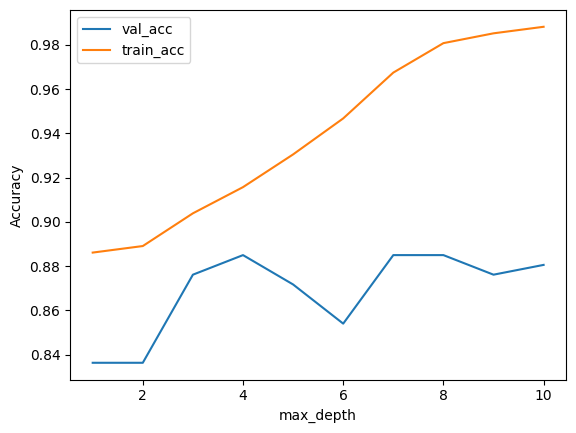

In [37]:
from sklearn.tree import DecisionTreeClassifier
val_acc=[]
train_acc = []
# Train and evaluate Decision Tree model with varying max_depth
for i in range(1,11):
    tree_model = DecisionTreeClassifier(criterion='gini',max_depth=i,random_state=1)
    tree_model.fit(X_train_desc, y_train)
    y_pred = tree_model.predict(X_val_desc)
    print(f"Validation Accuracy (for max_depth : {i}) : {np.mean(y_pred==y_val)}",end="  |  ")
    val_acc.append(np.mean(y_pred==y_val))
    y_pred = tree_model.predict(X_train_desc)
    print(f"Train Accuracy (for max_depth : {i}) : {np.mean(y_pred==y_train)}")
    train_acc.append(np.mean(y_pred==y_train))
plt.plot(np.arange(1,11,1),val_acc,label="val_acc")
plt.plot(np.arange(1,11,1),train_acc,label="train_acc")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


**Analysis:** The plot shows that val accuracy peaks at `max_depth=4` and `max_depth=7` and then starts to decrease, indicating **overfitting** for deeper trees.

What we did above is an example of hyperparameter tuning. However, when we have a large number posssible hyperparameter values, tuning manually like this can get impractical.

Hence, we can use built-in functions in sklearn called GridSearchCV for hyperparameter search.

### 5.2 GridSearchCV for Optimal Hyperparameters

Use GridSearchCV to systematically search for the best combination of hyperparameters for the Decision Tree classifier.

**Hyperparameters to tune:**
- `max_depth`: Maximum depth of the tree
- `min_samples_split`: Minimum samples required to split a node
- `min_samples_leaf`: Minimum samples required at a leaf node
- `criterion`: Split quality measure (gini or entropy)

In [38]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy']
}

# Create GridSearchCV object
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=1),
    dt_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
print("Performing Grid Search for Decision Tree...")
dt_grid.fit(X_train_desc_cv, y_train_cv)

print("Best Decision Tree Parameters:", dt_grid.best_params_)
print(f"Best Cross-Validation Score: {dt_grid.best_score_:.4f}")

Performing Grid Search for Decision Tree...
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Cross-Validation Score: 0.8902


### 5.3 Train Final Decision Tree Model

Train the decision tree with optimal hyperparameters from GridSearchCV and evaluate comprehensive performance metrics.

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1-Score : Harmonic Mean of Precision and Recall = 2/(1/P + 1/R)

Train Accuracy: 0.9224
Test Accuracy: 0.8584
Precision: 0.8792, Recall: 0.9034, F1-Score: 0.8912
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        81
           1       0.88      0.90      0.89       145

    accuracy                           0.86       226
   macro avg       0.85      0.84      0.84       226
weighted avg       0.86      0.86      0.86       226


Confusion Matrix:


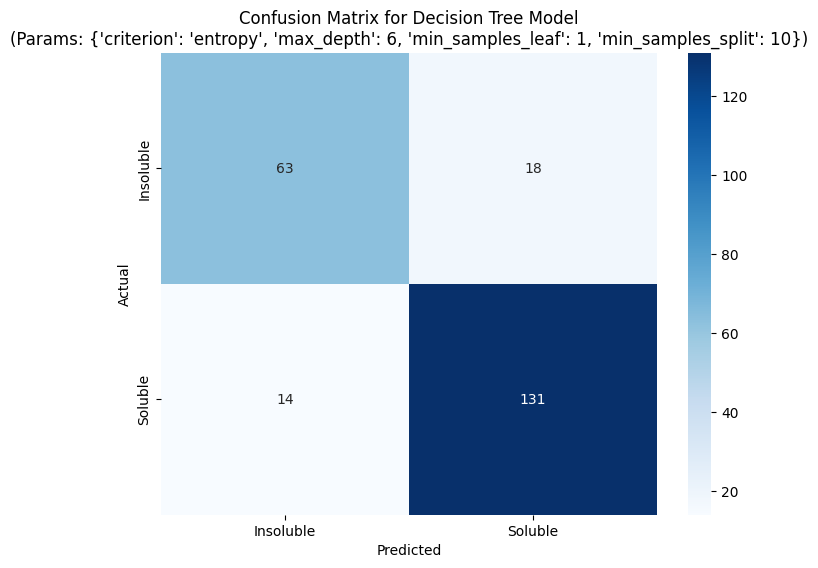

In [39]:
from sklearn.metrics import classification_report
# Use best parameters from GridSearchCV
tree_model = dt_grid.best_estimator_

# Train model
tree_model.fit(X_train_desc_cv, y_train_cv)

# Evaluate on training set
y_pred_train = tree_model.predict(X_train_desc_cv)
train_accuracy = np.mean(y_pred_train == y_train_cv)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Evaluate on test set
y_pred = tree_model.predict(X_test_desc)
test_accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate Precision, Recall, and F1 Score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

print(classification_report(y_test, y_pred))

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Insoluble', 'Soluble'], yticklabels=['Insoluble', 'Soluble'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Decision Tree Model\n(Params: {dt_grid.best_params_})')
plt.show()

### 5.4 ROC-AUC Curve for Decision Tree

Evaluate the Decision Tree's ability to discriminate between soluble and insoluble molecules using ROC curve and AUC score.

ROC curve plots TPR vs FPR for different probability thresholds.

TPR = TP / (TP + FN)

FPR = FP / (TN + FP)

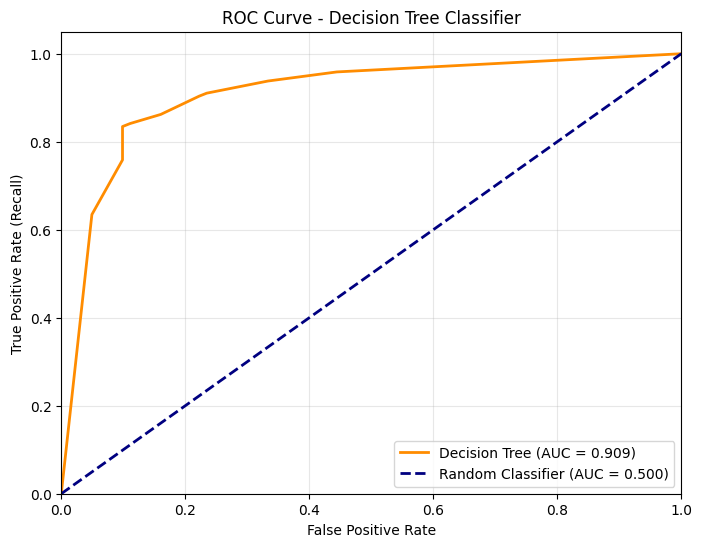

Decision Tree ROC-AUC Score: 0.9089


In [40]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get probability predictions for Decision Tree
y_pred_proba_dt = tree_model.predict_proba(X_test_desc)[:, 1]

# Calculate ROC curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Decision Tree ROC-AUC Score: {roc_auc_dt:.4f}")

### 5.5 Visualize the Decision Tree

Visualizing the tree helps us understand which features are most important and how the model makes decisions.

In [41]:
#Plot the decision tree
from sklearn import tree
plt.figure(figsize=(100, 100))
tree.plot_tree(tree_model,feature_names=["MolWt",'LogP','NumHDonors','NumHAcceptors','TPSA','NumRotatableBonds','AromaticProportion', 'NonCarbonProportion'],filled=True)
plt.show()

**Observation:** Many early splits in the tree are based on **LogP** (partition coefficient). This suggests LogP is a dominant feature.

---

## 6. Random Forest Classifier

Random Forests are ensemble methods that combine multiple decision trees to improve prediction accuracy and reduce overfitting.

**Key concepts:**
- **Ensemble learning**: Combining multiple weak learners
- **Bootstrap aggregating (bagging)**: Training each tree on a random subset of data
- **Feature randomness**: Each split considers only a random subset of features

### 6.1 Prepare Data for Random Forest

In [42]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['SMILES'].values, df['is_soluble'].values,
    test_size=0.2, random_state=42
)
descriptor_functions = [
    ('MolWt', Descriptors.MolWt),
    ('LogP', Descriptors.MolLogP),
    ('NumHDonors', Descriptors.NumHDonors),
    ('NumHAcceptors', Descriptors.NumHAcceptors),
    ('TPSA', Descriptors.TPSA),
    ('NumRotatableBonds', Descriptors.NumRotatableBonds),
]
# Calculate descriptors
X_train_desc = calculate_molecular_descriptors(X_train,descriptor_functions)
X_test_desc = calculate_molecular_descriptors(X_test,descriptor_functions)
print("X_train_desc keys : ",X_train_desc.columns.tolist())

X_train_desc keys :  ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'AromaticProportion', 'NonCarbonProportion']


### 6.2 GridSearchCV for Random Forest

Use GridSearchCV to find the optimal hyperparameters for the Random Forest classifier.

Important hyperparameters :

**n_estimators**: The number of individual decision trees to build in the forest

**max_depth**: The maximum number of levels each tree can grow

**min_samples_split**: The minimum number of data points required in a node before it is allowed to be split into two smaller nodes.

**min_samples_leaf**: The minimum number of data points that must exist in a resulting leaf node

**max_features**: The size of the random subset of features (columns) considered at each split, which ensures the trees in the forest are different from one another.

In [43]:
# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create GridSearchCV object
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=1),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
print("Performing Grid Search for Random Forest...")
rf_grid.fit(X_train_desc, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print(f"Best Cross-Validation Score: {rf_grid.best_score_:.4f}")

Performing Grid Search for Random Forest...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Random Forest Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.9146


### 6.4 Train Final Random Forest Model

Train the Random Forest with optimal parameters from GridSearchCV and evaluate comprehensive performance metrics.

Train Accuracy: 0.9889
Test Accuracy: 0.8938
Precision: 0.8954, Recall: 0.9448, F1-Score: 0.9195
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        81
           1       0.90      0.94      0.92       145

    accuracy                           0.89       226
   macro avg       0.89      0.87      0.88       226
weighted avg       0.89      0.89      0.89       226


Confusion Matrix:


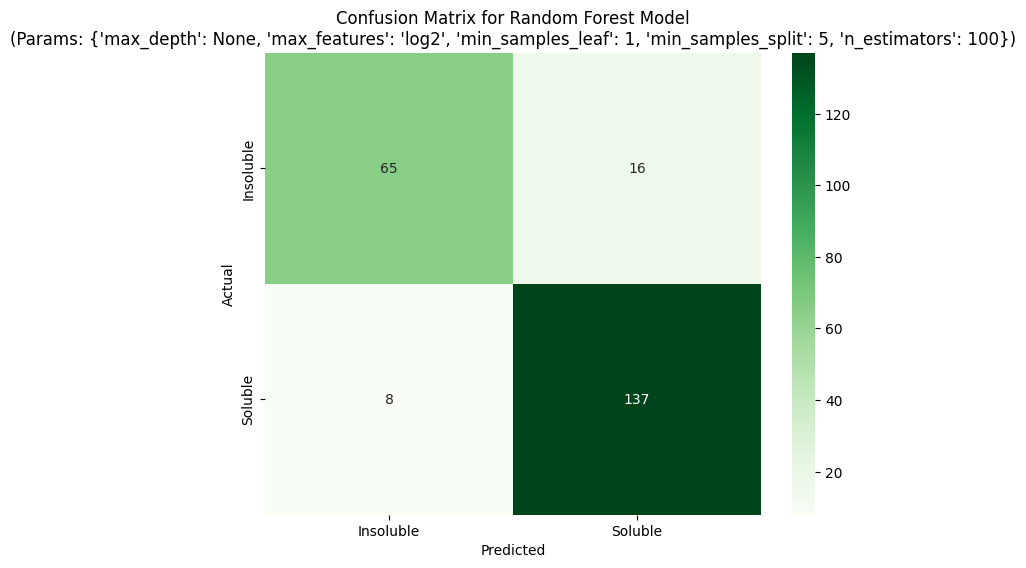

In [44]:
# Use best parameters from GridSearchCV
forest = rf_grid.best_estimator_

# Train model
forest.fit(X_train_desc, y_train)

# Evaluate on training set
y_pred_train = forest.predict(X_train_desc)
train_accuracy = np.mean(y_pred_train == y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Evaluate on test set
y_pred = forest.predict(X_test_desc)
test_accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
print(classification_report(y_test,y_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Insoluble', 'Soluble'], yticklabels=['Insoluble', 'Soluble'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Random Forest Model\n(Params: {rf_grid.best_params_})')
plt.show()

### 6.6 Feature Importance Analysis

Analyze which molecular descriptors are most important for the Random Forest model's predictions.

Feature Importance Ranking:
LogP                : 0.5198
MolWt               : 0.1958
NonCarbonProportion : 0.0874
TPSA                : 0.0596
NumHAcceptors       : 0.0430
AromaticProportion  : 0.0389
NumRotatableBonds   : 0.0352
NumHDonors          : 0.0202


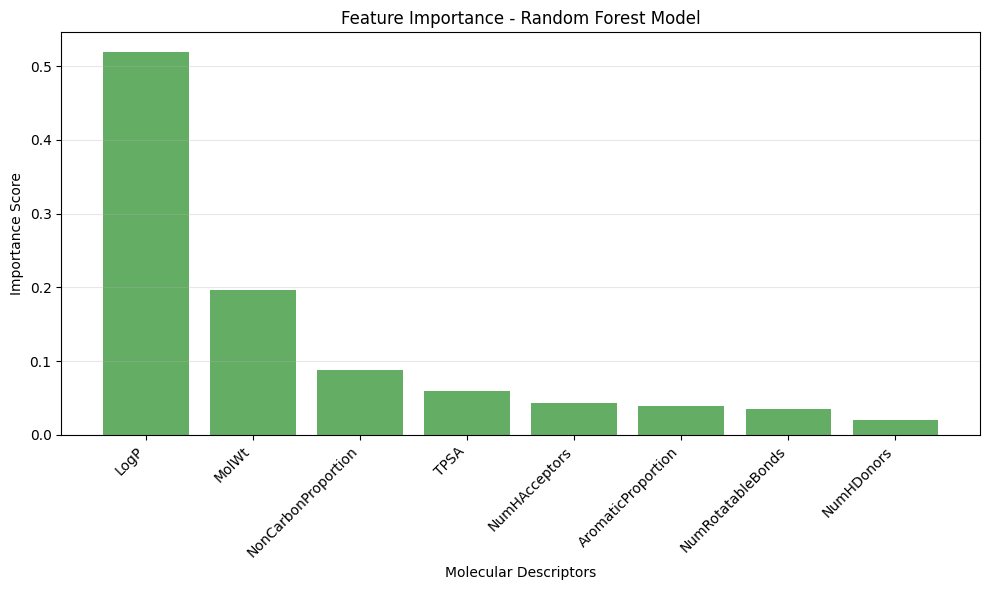

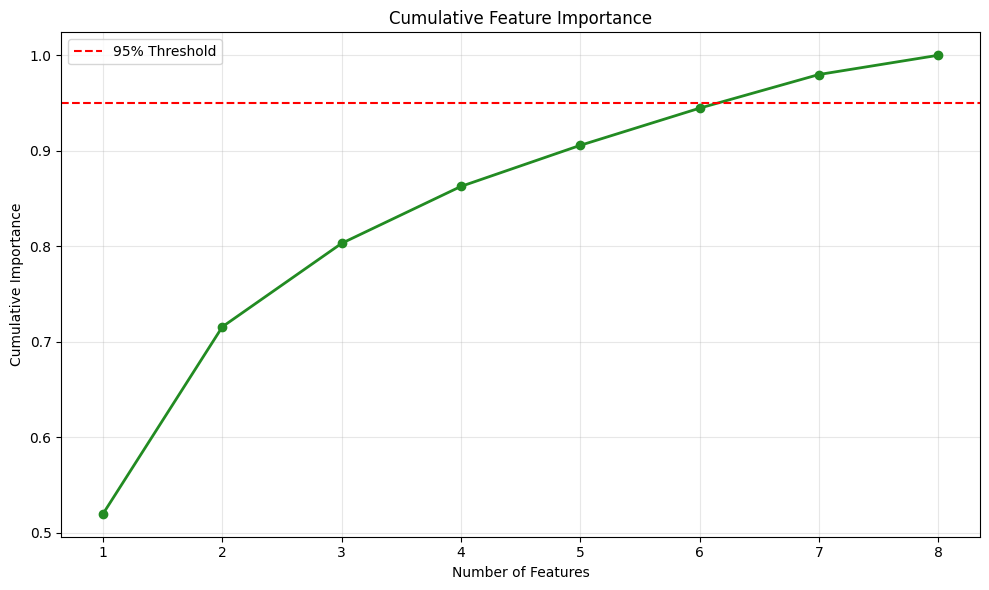

In [45]:
# Get feature importances
feature_importance = forest.feature_importances_
feature_names = X_train_desc.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']:20s}: {row['Importance']:.4f}")

# Plot feature importances
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importance)[::-1]

plt.bar(range(len(feature_importance)), feature_importance[indices], color='forestgreen', alpha=0.7)
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Molecular Descriptors')
plt.ylabel('Importance Score')
plt.title('Feature Importance - Random Forest Model')
plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# Show cumulative importance
cumulative_importance = np.cumsum(feature_importance[indices])
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', color='forestgreen', linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

### 6.5 ROC-AUC Curve Comparison

Compare the ROC curves of both Decision Tree and Random Forest models to evaluate their discrimination ability.

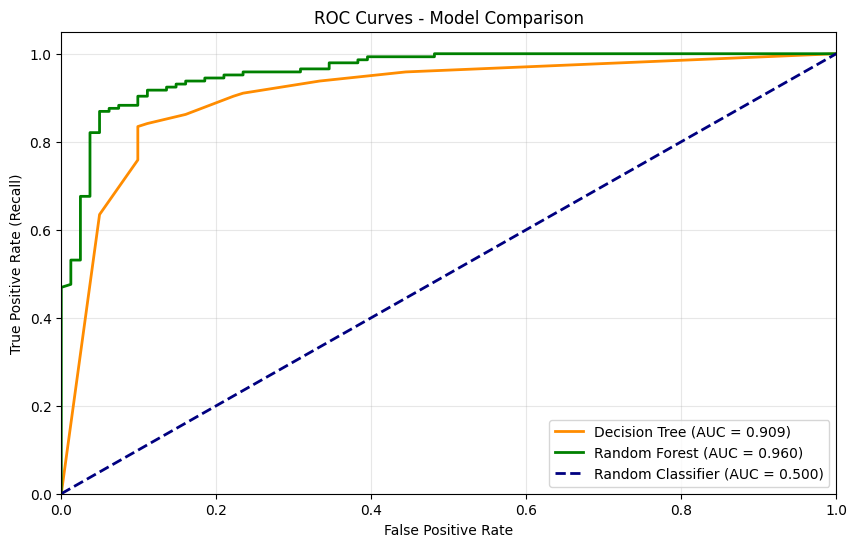

Decision Tree ROC-AUC Score: 0.9089
Random Forest ROC-AUC Score: 0.9605
Improvement: 0.0516


In [46]:
# Get probability predictions for Random Forest
y_pred_proba_rf = forest.predict_proba(X_test_desc)[:, 1]

# Calculate ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot comparison of both models
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Decision Tree ROC-AUC Score: {roc_auc_dt:.4f}")
print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.4f}")
print(f"Improvement: {(roc_auc_rf - roc_auc_dt):.4f}")

## Conclusion

### 1. **Decision Tree Performance**
- **Best Hyperparameters**: GridSearchCV identified optimal parameters for tree complexity
- **Interpretability**: Single decision tree provides clear decision rules
- **Feature Importance**: LogP emerged as the most influential descriptor for early splits
- **Overfitting Risk**: Deeper trees (max_depth > 6) showed signs of overfitting

#### 2. **Random Forest Performance**
- **Improved Generalization**: Ensemble approach reduced overfitting compared to single tree
- **Superior Metrics**: Outperformed Decision Tree across all evaluation metrics
- **ROC-AUC**: Higher AUC indicates better discrimination between classes

#### 3. **Feature Analysis**
The most important molecular descriptors for solubility prediction:

1. **LogP (Partition Coefficient)**: Dominant predictor - measures lipophilicity
2. **MolWt (Molecular Weight)**: Heavy molecules tend to be less soluble
3. **Non-carbon proportion** : Heteroatoms (typically Oxygen, Nitrogen, Sulfur, and Halogens) can increase aqueous solubility
4. **TPSA (Topological Polar Surface Area)**: Polarity influences water solubility

**Key Observation**: LogP and MolWt together account for ~70% of predictive power, suggesting these physicochemical properties are primary predictors of solubility.


## Further tasks you can try :

#### **A. Hyperparameter Optimization**
```python
# Try RandomizedSearchCV for faster hyperparameter search
from sklearn.model_selection import RandomizedSearchCV
```

#### **B. Additional Molecular Descriptors**
```python
# Add more RDKit descriptors
from rdkit.Chem import Descriptors
```

#### **C. Try training model with just most important 3-4 features and compare performance**


